In [227]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Helper Functions

In [228]:
def add_noise(df, scale):
    noise = pd.DataFrame(np.random.normal(loc=0, scale=scale, size=df.shape), columns=df.columns)

    df_noisy = noise.add(df)

    return df_noisy

In [229]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values.astype(np.float32)).to(device)

# Prepare Data

In [230]:
# read data
spectrum_train = pd.read_excel('spectrum_train.xlsx')
spectrum_test = pd.read_excel('spectrum_valid.xlsx')
temp_train = pd.read_excel('temp_train.xlsx')
temp_test = pd.read_excel('temp_valid.xlsx')

In [231]:
# scale spectrum data
data_scale = 10**12
spectrum_train = spectrum_train.multiply(data_scale)
spectrum_test = spectrum_test.multiply(data_scale)

In [232]:
from sklearn.model_selection import train_test_split
# set train and test data

# 1 - temp to spectrum
# 0 - spectrum to temp
direction = 0

# use only if split == 1
# 1 - combine given training and validation data
# 0 - use only training data
combine = 0

# 1 - noise added to training data
# 0 - no noise added
noise_scale = 0.01
noise = 0

if noise:
    if direction:
        temp_train = add_noise(temp_train, noise_scale)
    else:
        spectrum_train = add_noise(spectrum_train, noise_scale)

if not combine:
    if direction:
        X_train = temp_train
        X_test = temp_test
        y_train = spectrum_train
        y_test = spectrum_test
    else:
        X_train = spectrum_train
        X_test = spectrum_test
        y_train = temp_train
        y_test = temp_test
else:
    spectrum = pd.concat([spectrum_train, spectrum_test], axis=0)
    temp = pd.concat([temp_train, temp_test], axis=0)
    if direction:
        X_train, X_test, y_train, y_test = train_test_split(temp, spectrum, test_size=0.3, random_state=101)
    else:
        X_train, X_test, y_train, y_test = train_test_split(spectrum, temp, test_size=0.3, random_state=101)

In [233]:
y_train_layers = []
y_test_layers = []

for index in range(y_train.shape[1]):
    col = pd.DataFrame(y_train.iloc[:, index])
    y_train_layers.append(col)

    col = pd.DataFrame(y_test.iloc[:, index])
    y_test_layers.append(col)

In [234]:
# create input and output tensors
X = df_to_tensor(X_train)
y = df_to_tensor(y_train_layers[0])

In [235]:
n_samples, input_size = X.shape
output_size = 1

# Design Model 
(input size, output size, forward pass)

In [236]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 30)
        self.lin2 = nn.Linear(30, 15)
        self.lin3 = nn.Linear(15, 5)
        self.lin_fin = nn.Linear(5, output_size)

    def forward(self, x):
        output = F.leaky_relu(self.lin1(x))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin3(output))
        output = self.lin_fin(output)
        return output

In [237]:
model = Net(input_size=input_size, output_size=output_size)

# Construct Loss and Optimizer

In [238]:
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop

In [239]:
loss_list = []
num_epochs = 1000

for epoch in range(num_epochs):
    # forward pass and loss
    y_predicted = model(X)
    loss = criterion(y_predicted, y)
    loss_list.append(loss.item())

    # backward pass
    loss.backward()

    # update
    optimizer.step()

    # empty gradients
    optimizer.zero_grad()

    if (epoch+1) % int(num_epochs/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss:.4f}')

epoch: 100, loss = 19552.4668
epoch: 200, loss = 13732.0977
epoch: 300, loss = 783.1425
epoch: 400, loss = 765.9246
epoch: 500, loss = 763.7468
epoch: 600, loss = 762.3862
epoch: 700, loss = 758.5848
epoch: 800, loss = 758.6714
epoch: 900, loss = 756.8422
epoch: 1000, loss = 755.0433


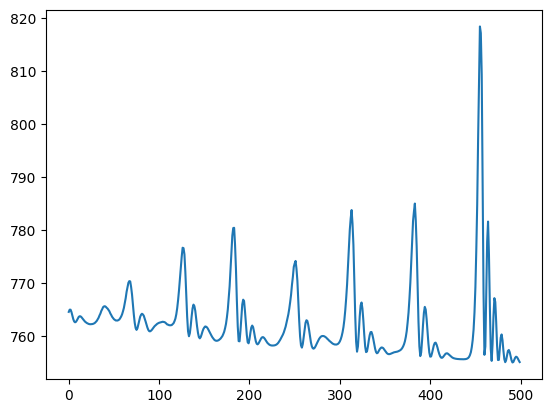

In [240]:
plt.plot(loss_list[-500:num_epochs])